## Graph Neural Network

References:
- [Explainable Graph Neural Networks with Data Augmentation for Predicting pKa of C–H Acids](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00958)
- [MolGpka: A Web Server for Small Molecule pKa Prediction Using a Graph-Convolutional Neural Network](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00075)

In [1]:
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import RGATConv
from torch_geometric.nn.pool import global_mean_pool
import rdkit.Chem as Chem

# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
infile = "../data/combined_training_datasets_unique_graph_training.pkl"
ratio = 0.1
batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data

In [2]:
TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.OTHER,
    ]
TYPE2DCT = {t: idx for idx, t in enumerate(TYPES)}

ATOMS = ['C', 'O', 'S', 'N', 'P', 'H', 'F', 'Cl', 'Br', 'I', 'UNK']
ATOM2DCT = {ele: np.eye(len(ATOMS))[idx] for idx, ele in enumerate(ATOMS)}

In [3]:
with open(infile, "rb") as file:
    DATA = pickle.load(file)
nsamples = len(DATA)
print(f"Number of samples: {nsamples}")

val_size = int(nsamples*ratio)
train_data = DATA[:val_size]
test_data = DATA[val_size:]

d = train_data[0][0]
ndim = d.x.shape[1]
num_relations = len(TYPES)
print(f"Dimension of node feature: {ndim}")
print(f"Number of edge types: {num_relations}")

/home/mxue33/anaconda3/envs/sphinx/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Number of samples: 5994
Dimension of node feature: 11
Number of edge types: 5


### Graph Batching

In [4]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Model

In [22]:
class Model(nn.Module):
    def __init__(self, ndim, hidden_dims, num_relations, type):
        super(Model, self).__init__()
        total_dims = [ndim] + hidden_dims
        net = []
        for i in range(len(total_dims)-1):
            net.extend([
                RGATConv(total_dims[i], total_dims[i+1], num_relations),
                nn.ReLU(),
                nn.BatchNorm1d(total_dims[i+1])
            ])
        self.net = nn.Sequential(*net)
        self.fc = nn.Linear(total_dims[-1], 1)
        self.type = type
        

    def forward(self, data):
        batch = data.batch
        out = data.x
        if self.type == "float":
            out = out.float()
        elif self.type == "double":
            out = out.double()
        else:
            raise TypeError(f"{self.type} not supported")
        edge_index = data.edge_index.long()
        edge_type = data.edge_type.long()
        for idx in range(len(self.net)//3):
            out = self.net[3*idx](out, edge_index, edge_type)
            out = self.net[3*idx+1](out)
            out = self.net[3*idx+2](out)
        out = global_mean_pool(out, batch)
        out = self.fc(out)
        return out

In [23]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [24]:
epochs = 20
lr = 1e-2
dtype = "float"
model = Model(ndim, hidden_dims=[100, 50, 20], num_relations=num_relations, type=dtype)
model.to(device)
model = model.float() if dtype == "float" else model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

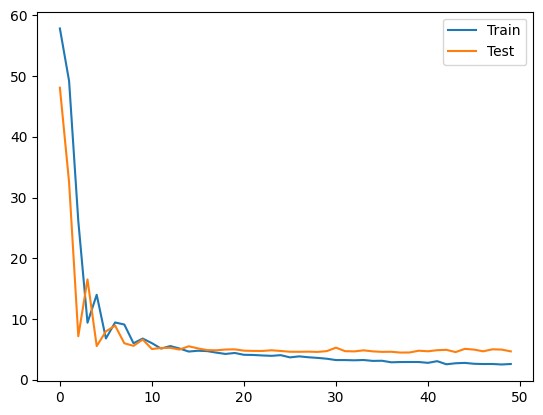

In [18]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(4.7215)


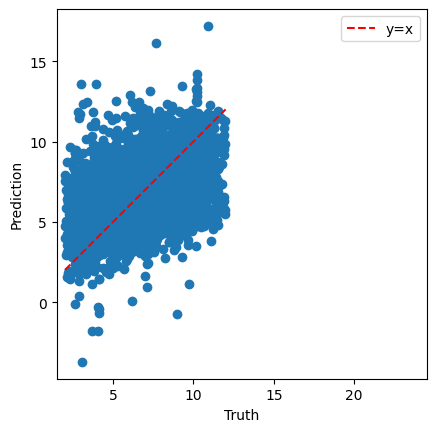

In [14]:
model.eval()

truth = []
pred = []
with torch.no_grad():
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        truth.extend(y.cpu().numpy().tolist())
        pred.extend(y_pred.cpu().numpy().tolist())
loss = loss_func(torch.Tensor(pred), torch.Tensor(truth))
print(loss)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()